In [3]:
# Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
plt.rcParams['figure.figsize'] = [10, 8]
import warnings
warnings.filterwarnings("ignore")


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# -----------------------------------------------
# Load and Prepare JJ Dataset
# -----------------------------------------------
jj_df = pd.read_csv('/content/drive/MyDrive/jj.csv')
jj_df.columns = ['date', 'value']
jj_df['date'] = pd.to_datetime(jj_df['date'])
jj_df.set_index('date', inplace=True)

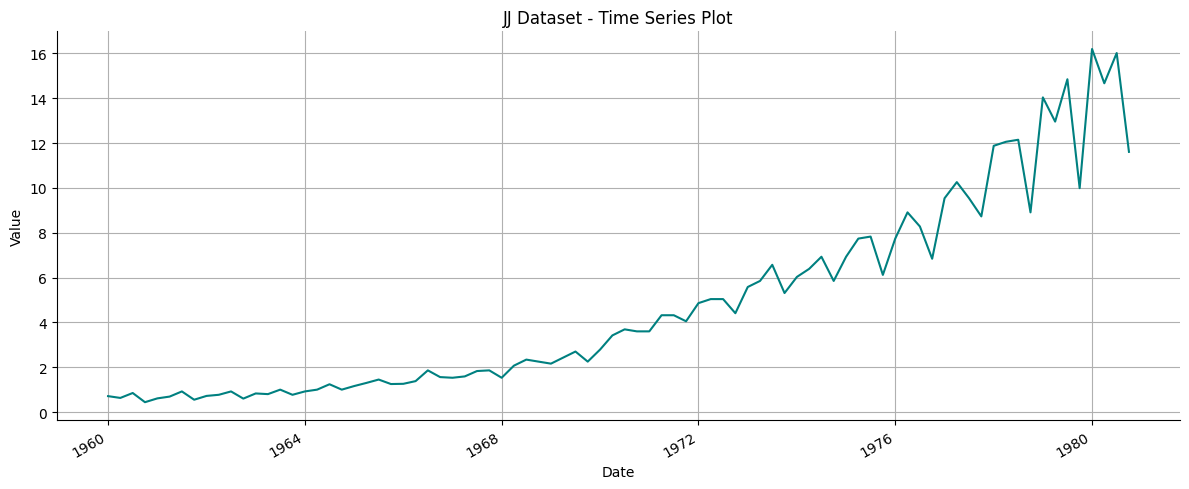

In [7]:
# Line plot of the JJ dataset
jj_df['value'].plot(kind='line', title='JJ Dataset - Time Series Plot', color='teal', figsize=(12, 5))
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid(True)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

In [8]:
jj_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 84 entries, 1960-01-01 to 1980-10-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   84 non-null     float64
dtypes: float64(1)
memory usage: 1.3 KB


**Test For Non-Stationary**

In [9]:
from statsmodels.tsa.stattools import adfuller

# ADF Test on Level Data
adf_lvl = adfuller(jj_df['value'].dropna())
print("ADF Test p-value (Level):", adf_lvl[1])

# ADF Test on First Difference
adf_1st_diff = adfuller(jj_df['value'].diff().dropna())
print("ADF Test p-value (1st Difference):", adf_1st_diff[1])

# ADF Test on Second Difference
adf_2nd_diff = adfuller(jj_df['value'].diff().diff().dropna())
print("ADF Test p-value (2nd Difference):", adf_2nd_diff[1])

ADF Test p-value (Level): 1.0
ADF Test p-value (1st Difference): 0.9088542416911305
ADF Test p-value (2nd Difference): 0.006051099869603682


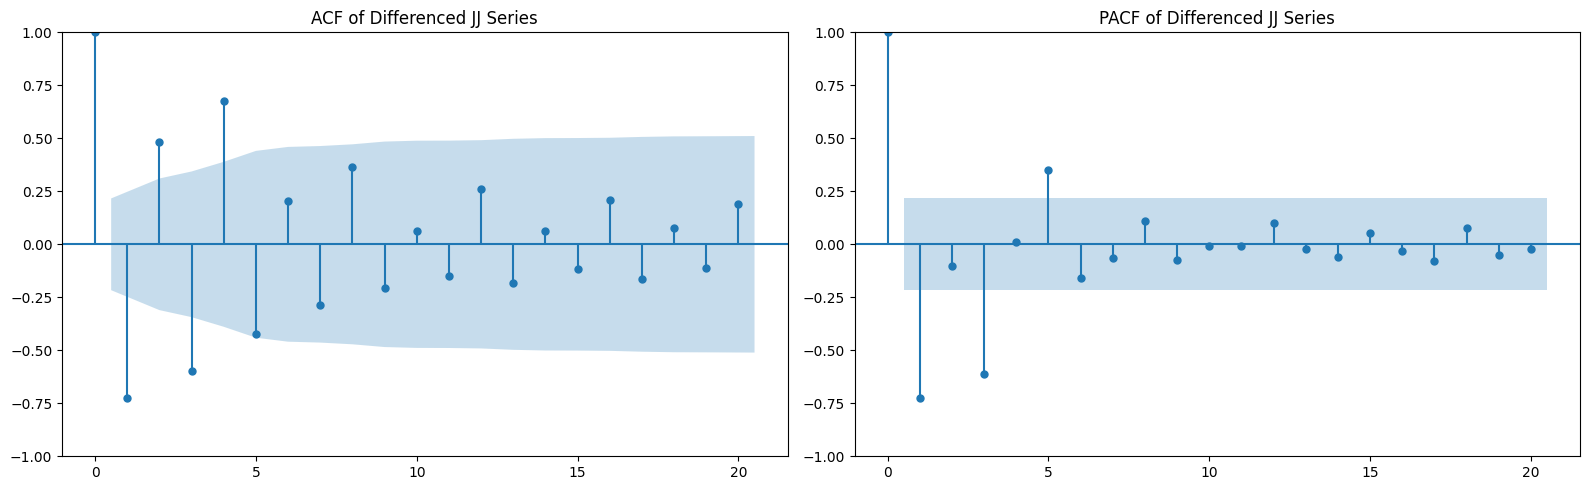

In [10]:
# Apply second-order differencing
diff_data = jj_df['value'].diff().dropna().diff().dropna()

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
plot_acf(diff_data, lags=20, ax=axes[0])
axes[0].set_title("ACF of Differenced JJ Series")
plot_pacf(diff_data, lags=20, ax=axes[1])
axes[1].set_title("PACF of Differenced JJ Series")
plt.tight_layout()
plt.show()

In [11]:
# Grid Search for Best ARIMA(p, 2, q)
lowest_aic = float("inf")
best_order = None
best_model = None

for p in range(4):
    for q in range(4):
        try:
            model = ARIMA(jj_df['value'], order=(p, 2, q)).fit()
            if model.aic < lowest_aic:
                lowest_aic = model.aic
                best_order = (p, 2, q)
                best_model = model
        except:
            continue

print("Best ARIMA Order (p, d=2, q):", best_order)

Best ARIMA Order (p, d=2, q): (3, 2, 3)


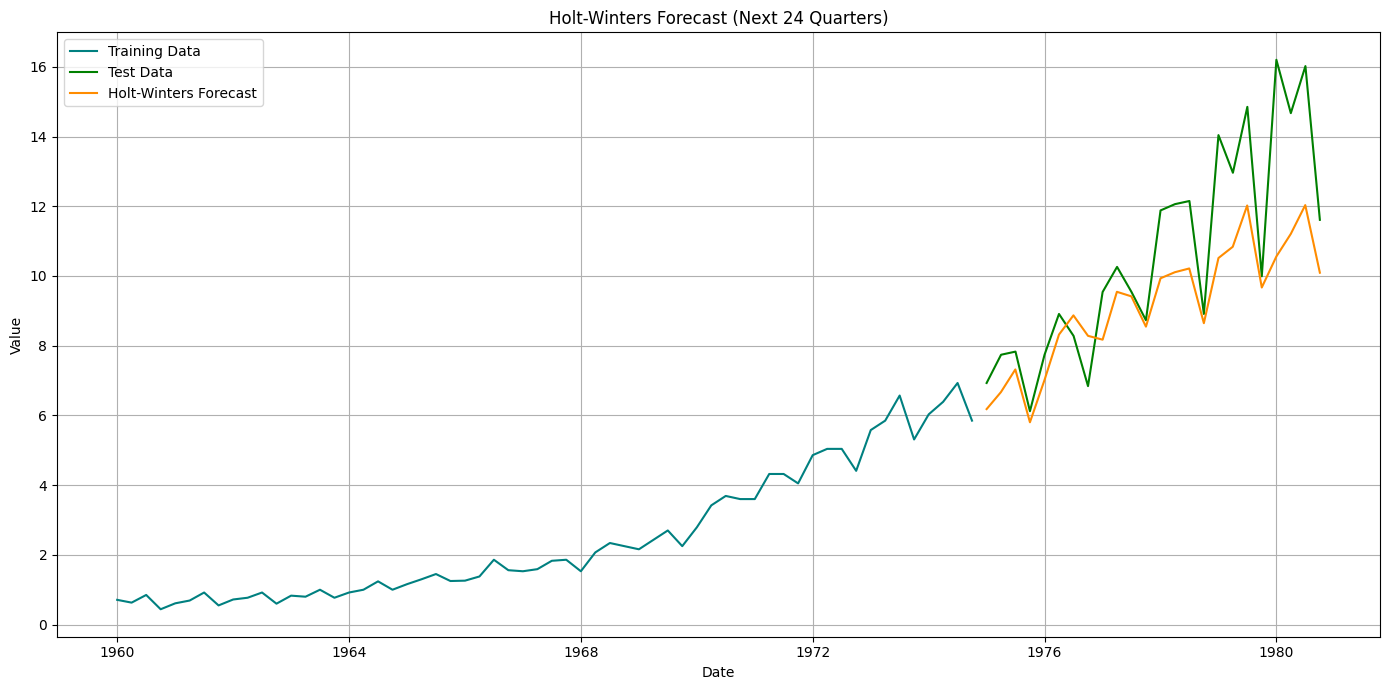

MAE  : 1.5787
MSE  : 4.4277
RMSE : 2.1042


In [13]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# 1. Copy original dataset
jj_smooth = jj_df.copy()

# 2. Optional moving average smoothing
jj_smooth['6Q-SMA'] = jj_smooth['value'].rolling(window=6).mean()
jj_smooth['12Q-SMA'] = jj_smooth['value'].rolling(window=12).mean()
jj_smooth['EWMA-12'] = jj_smooth['value'].ewm(span=12, adjust=False).mean()

# 3. Train-test split
test_size = 24
train_data = jj_smooth[:-test_size]
test_data = jj_smooth[-test_size:]

# 4. Fit Exponential Smoothing model
hw_model = ExponentialSmoothing(
    train_data['value'],
    trend='add',
    seasonal='mul',
    seasonal_periods=24
)
hw_fitted = hw_model.fit()

# 5. Forecast for 24 quarters
forecast_horizon = 24
forecast_dates = pd.date_range(
    start=train_data.index[-1] + pd.DateOffset(months=3),
    periods=forecast_horizon,
    freq='QS'
)
hw_forecast = hw_fitted.forecast(forecast_horizon)
hw_forecast_series = pd.Series(hw_forecast.values, index=forecast_dates, name='Forecast')

# 6. Plot results
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data['value'], label='Training Data', color='teal')
plt.plot(test_data.index, test_data['value'], label='Test Data', color='green')
plt.plot(hw_forecast_series.index, hw_forecast_series, label='Holt-Winters Forecast', color='darkorange')
plt.title("Holt-Winters Forecast (Next 24 Quarters)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Evaluation on test set
hw_eval = hw_forecast_series[:len(test_data)]
mae = mean_absolute_error(test_data['value'], hw_eval)
mse = mean_squared_error(test_data['value'], hw_eval)
rmse = np.sqrt(mse)

print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")

**Build an RNN based model (LSTM, GRU)**

Epoch 1/50
8/8 - 5s - 658ms/step - loss: 0.1378 - val_loss: 0.5571
Epoch 2/50
8/8 - 0s - 27ms/step - loss: 0.0951 - val_loss: 0.3995
Epoch 3/50
8/8 - 0s - 37ms/step - loss: 0.0776 - val_loss: 0.2645
Epoch 4/50
8/8 - 0s - 19ms/step - loss: 0.0722 - val_loss: 0.1614
Epoch 5/50
8/8 - 0s - 17ms/step - loss: 0.0580 - val_loss: 0.1249
Epoch 6/50
8/8 - 0s - 18ms/step - loss: 0.0374 - val_loss: 0.1007
Epoch 7/50
8/8 - 0s - 17ms/step - loss: 0.0350 - val_loss: 0.1046
Epoch 8/50
8/8 - 0s - 18ms/step - loss: 0.0375 - val_loss: 0.1390
Epoch 9/50
8/8 - 0s - 26ms/step - loss: 0.0291 - val_loss: 0.0949
Epoch 10/50
8/8 - 0s - 43ms/step - loss: 0.0390 - val_loss: 0.1008
Epoch 11/50
8/8 - 0s - 32ms/step - loss: 0.0318 - val_loss: 0.0976
Epoch 12/50
8/8 - 0s - 38ms/step - loss: 0.0220 - val_loss: 0.0936
Epoch 13/50
8/8 - 0s - 32ms/step - loss: 0.0310 - val_loss: 0.1005
Epoch 14/50
8/8 - 0s - 38ms/step - loss: 0.0265 - val_loss: 0.0997
Epoch 15/50
8/8 - 0s - 35ms/step - loss: 0.0240 - val_loss: 0.1067
Epo

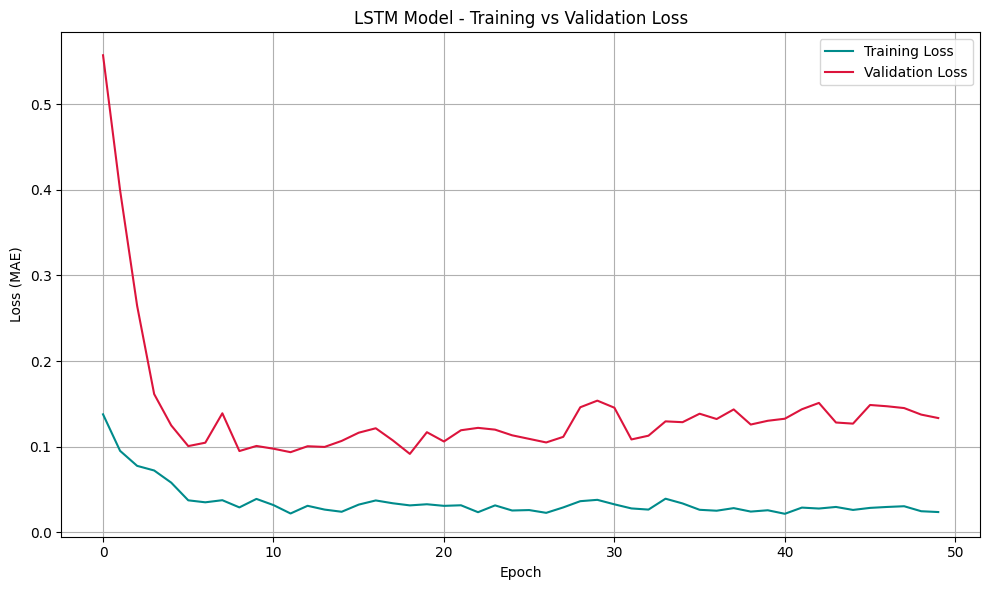

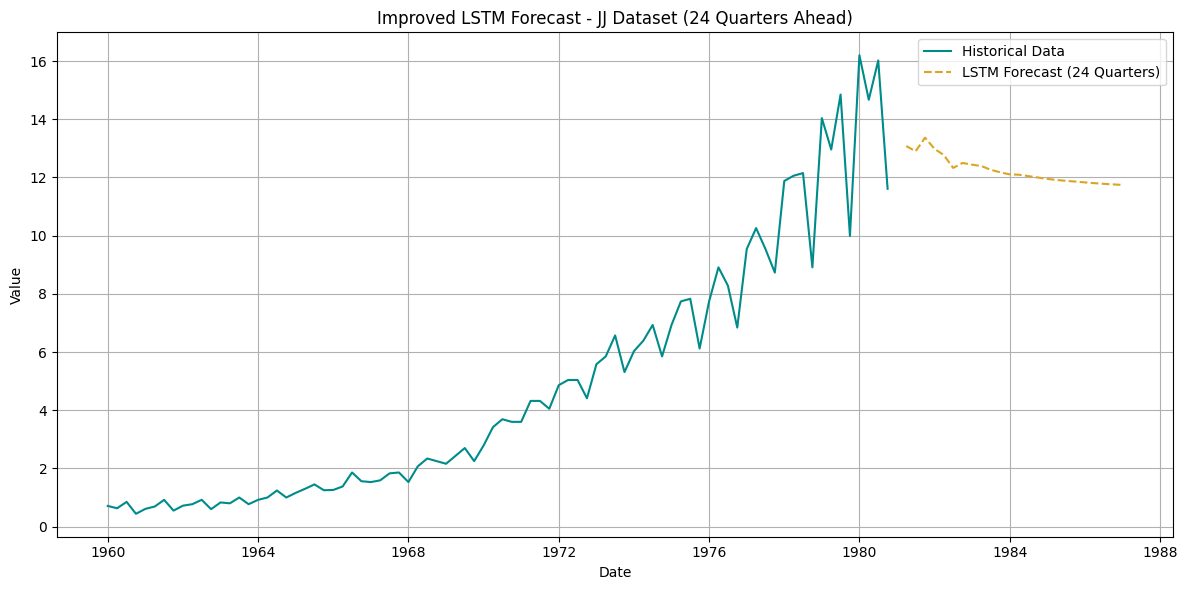

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
LSTM Model Evaluation Metrics:
MAE  : 2.1031
MSE  : 5.3788
RMSE : 2.3192
R²   : 0.0807


In [17]:
from pandas import DataFrame, concat
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# -------------------------------------------------
# Load and Normalize JJ Dataset
# -------------------------------------------------
jj_df = pd.read_csv('/content/drive/MyDrive/jj.csv')
jj_df.columns = ['date', 'value']
jj_df['date'] = pd.to_datetime(jj_df['date'])
jj_df.set_index('date', inplace=True)

# Normalize the 'value' column
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(jj_df[['value']].values.astype('float32'))

# -------------------------------------------------
# Convert Time Series to Supervised Format
# -------------------------------------------------
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = data.shape[1]
    df = DataFrame(data)
    cols, names = [], []

    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [f'var{j+1}(t-{i})' for j in range(n_vars)]

    for i in range(0, n_out):
        cols.append(df.shift(-i))
        names += [f'var{j+1}(t+{i})' for j in range(n_vars)]

    agg = concat(cols, axis=1)
    agg.columns = names

    if dropnan:
        agg.dropna(inplace=True)

    return agg

# Use 6 past time steps
supervised_df = series_to_supervised(scaled_values, n_in=6, n_out=1)

# -------------------------------------------------
# Prepare Training and Testing Data
# -------------------------------------------------
X_all = supervised_df.iloc[:, :-1]
y_all = supervised_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, shuffle=False)

X_train = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

# -------------------------------------------------
# Build and Train LSTM Model
# -------------------------------------------------
lstm_model = Sequential()
lstm_model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(32))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))

lstm_model.compile(loss='mae', optimizer='adam')

history = lstm_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=8,
    validation_data=(X_test, y_test),
    verbose=2,
    shuffle=False
)

# -------------------------------------------------
# Plot Training History
# -------------------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='darkcyan')
plt.plot(history.history['val_loss'], label='Validation Loss', color='crimson')
plt.title('LSTM Model - Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------------------------------
# Forecast 24 Future Quarters
# -------------------------------------------------
last_input = scaled_values[-6:]
future_preds = []

for _ in range(24):
    seq_input = last_input.reshape((1, 6, 1))
    next_pred = lstm_model.predict(seq_input, verbose=0)[0][0]
    future_preds.append(next_pred)
    last_input = np.append(last_input[1:], [[next_pred]], axis=0)

# Inverse scale predictions
future_forecast = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

# Create future date range
last_known_date = jj_df.index[-1]
future_dates = pd.date_range(start=last_known_date + pd.DateOffset(months=3), periods=24, freq='Q')
future_df = pd.DataFrame(future_forecast, index=future_dates, columns=['Forecast'])

# -------------------------------------------------
# Plot Forecast
# -------------------------------------------------
plt.figure(figsize=(12, 6))
plt.plot(jj_df.index, jj_df['value'], label='Historical Data', color='darkcyan')
plt.plot(future_df.index, future_df['Forecast'], label='LSTM Forecast (24 Quarters)', color='goldenrod', linestyle='--')
plt.title('Improved LSTM Forecast - JJ Dataset (24 Quarters Ahead)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------------------------------
# Evaluate Model on Test Data
# -------------------------------------------------
y_pred_scaled = lstm_model.predict(X_test)
y_pred_actual = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.values.reshape(-1, 1))

mae = mean_absolute_error(y_test_actual, y_pred_actual)
mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, y_pred_actual)

print("LSTM Model Evaluation Metrics:")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0486 - val_loss: 0.1009
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0053 - val_loss: 0.0156
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0060 - val_loss: 0.0355
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0030 - val_loss: 0.0305
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0012 - val_loss: 0.0175
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0015 - val_loss: 0.0188
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 8.2463e-04 - val_loss: 0.0177
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


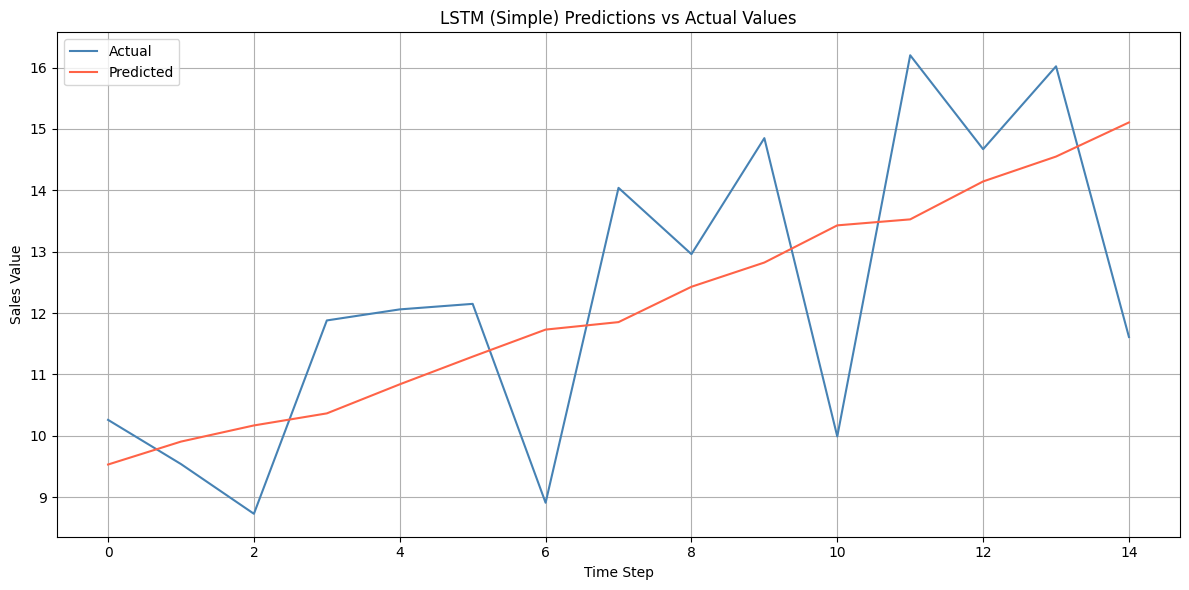

In [18]:
# -------------------------------------------------
# Normalize the JJ Dataset for LSTM
# -------------------------------------------------
scaler = MinMaxScaler()
jj_df[['value']] = scaler.fit_transform(jj_df[['value']])

# -------------------------------------------------
# Create Sequences for Time Series Supervision
# -------------------------------------------------
def create_sequences(data_series, seq_length):
    X, y = [], []
    for i in range(len(data_series) - seq_length):
        X.append(data_series[i:i+seq_length])
        y.append(data_series[i+seq_length])
    return np.array(X), np.array(y)

sequence_len = 12
X, y = create_sequences(jj_df['value'].values, sequence_len)
X = X.reshape((X.shape[0], X.shape[1], 1))

# -------------------------------------------------
# Split into Train and Test Sets
# -------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# -------------------------------------------------
# Define and Train LSTM Model
# -------------------------------------------------
lstm_model_simple = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(32, activation='relu'),
    Dense(1)
])
lstm_model_simple.compile(optimizer='adam', loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lstm_model_simple.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=8,
    callbacks=[early_stopping],
    verbose=1
)

# -------------------------------------------------
# Plot Predictions vs True Values
# -------------------------------------------------
def plot_predictions(model, X_test, y_test, model_name="Model"):
    predictions = model.predict(X_test)
    plt.figure(figsize=(12, 6))
    plt.plot(scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual', color='steelblue')
    plt.plot(scaler.inverse_transform(predictions), label='Predicted', color='tomato')
    plt.title(f"{model_name} Predictions vs Actual Values")
    plt.xlabel("Time Step")
    plt.ylabel("Sales Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# -------------------------------------------------
# Visualize Prediction Results
# -------------------------------------------------
plot_predictions(lstm_model_simple, X_test, y_test, "LSTM (Simple)")

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

# -----------------------------------------------
# Predict on the Test Set
# -----------------------------------------------
lstm_predictions_scaled = lstm_model_simple.predict(X_test)

# Inverse scaling to original scale
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_actual = scaler.inverse_transform(lstm_predictions_scaled).flatten()

# -----------------------------------------------
# Calculate Evaluation Metrics
# -----------------------------------------------
mae_lstm = mean_absolute_error(y_test_actual, y_pred_actual)
rmse_lstm = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
mape_lstm = mean_absolute_percentage_error(y_test_actual, y_pred_actual)

# -----------------------------------------------
# Output Model Performance
# -----------------------------------------------
print("LSTM Model Evaluation Metrics:")
print(f"MAE  : {mae_lstm:.4f}")
print(f"RMSE : {rmse_lstm:.4f}")
print(f"MAPE : {mape_lstm:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
LSTM Model Evaluation Metrics:
MAE  : 1.6865
RMSE : 1.9667
MAPE : 0.1441


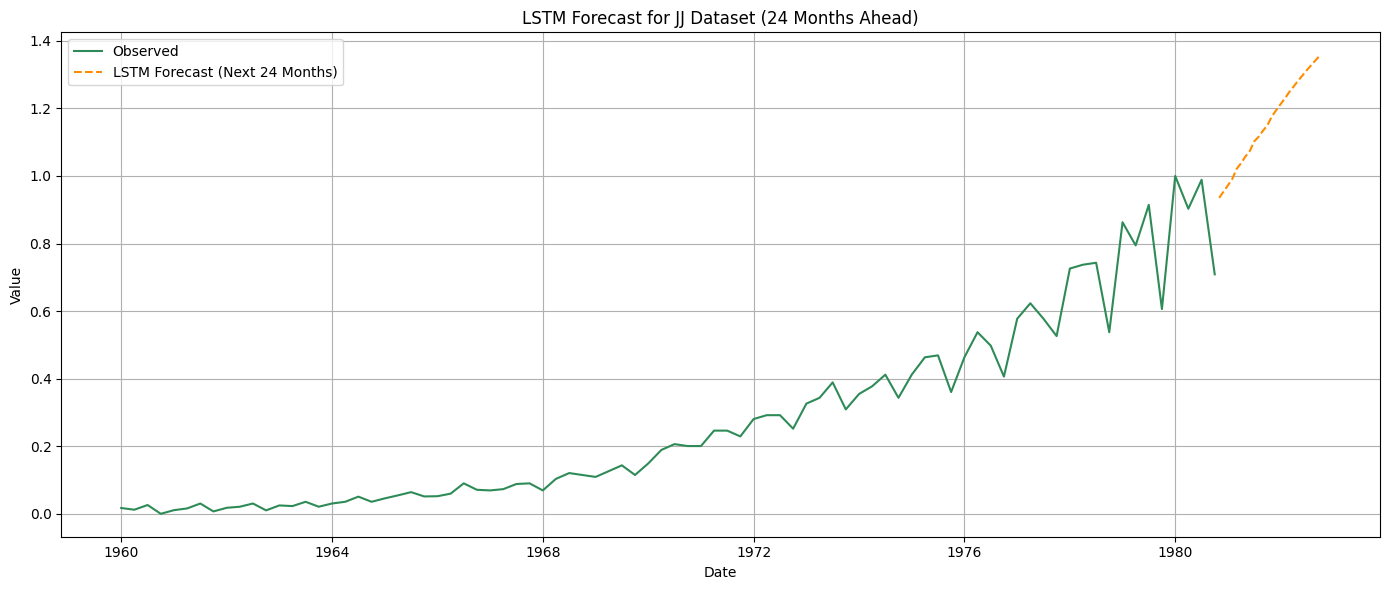

In [20]:
# -----------------------------------------------
# Forecasting Function for Future Values
# -----------------------------------------------
def forecast_future(model, scaled_data, scaler, n_future=24, seq_len=12):
    last_seq = scaled_data[-seq_len:].reshape(1, seq_len, 1)
    forecast = []

    for _ in range(n_future):
        next_pred = model.predict(last_seq, verbose=0)[0][0]
        forecast.append(next_pred)
        last_seq = np.append(last_seq[:, 1:, :], [[[next_pred]]], axis=1)

    return scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

# -----------------------------------------------
# Prepare Scaled Data for Forecasting
# -----------------------------------------------
scaler = MinMaxScaler()
scaled_series = scaler.fit_transform(jj_df['value'].values.reshape(-1, 1))

# Forecast the Next 24 Months (Monthly Intervals)
future_forecast = forecast_future(lstm_model_simple, scaled_series, scaler, n_future=24, seq_len=12)

# Generate future date range (Monthly frequency)
forecast_start = jj_df.index[-1] + pd.DateOffset(months=1)
future_dates = pd.date_range(start=forecast_start, periods=24, freq='MS')

# -----------------------------------------------
# Plot Observed vs Forecasted Data
# -----------------------------------------------
plt.figure(figsize=(14, 6))
plt.plot(jj_df.index, scaler.inverse_transform(scaled_series), label='Observed', color='seagreen')
plt.plot(future_dates, future_forecast, label='LSTM Forecast (Next 24 Months)', color='darkorange', linestyle='--')
plt.title('LSTM Forecast for JJ Dataset (24 Months Ahead)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()